## JIRA Bug report

In [1]:
import requests
import json
import os
from dotenv import load_dotenv

## Fetch DATA

In [2]:
#### Global variables

filterSKR01 = {"jql" : "filter = 10250"}
filterSKR10 = {"jql" : "filter = 10251"}

load_dotenv()

jira_token_path = os.environ.get('jr_token')
print(f"Getting token successful: {jira_token_path[:3]}...{jira_token_path[-3:]}")

Getting token successful: ATA...48F


In [3]:
# rsrc = "search"

# endpoint = "https://skrmobileapp.atlassian.net/rest/api/3/{resrc}".format( 
#     resrc = rsrc,
#     )

# jira_user = 'punnathorn.mingkwan@sikarin.com'
# auth = requests.auth.HTTPBasicAuth(jira_user, jira_token_path)
# head = {
#     "Accept": "application/json",
#     }

# response = requests.get(url = endpoint, headers = head, auth = auth, params = filterSKR01)
# # print("STATUS : {response.status_code}")

# allDefectSKR01 = json.loads(response.text)

# allDefectSKR01.keys()

In [4]:
def get_bug_skr(versions = filterSKR01) -> dict:
    rsrc = "search"

    endpoint = "https://skrmobileapp.atlassian.net/rest/api/3/{resrc}".format( 
        resrc = rsrc,
        )

    jira_user = 'punnathorn.mingkwan@sikarin.com'
    auth = requests.auth.HTTPBasicAuth(jira_user, jira_token_path)
    head = {
        "Accept": "application/json",
        }

    response = requests.get(url = endpoint, headers = head, auth = auth, params = versions)
    # print("STATUS : {response.status_code}")

    allDefectSKR01 = json.loads(response.text)

    ############################################
    ############################################
    ###### filter all bugs into a list
    ############################################
    ############################################

    bug_lists = {}
    for i in range(len(allDefectSKR01['issues'])):

        lin = allDefectSKR01['issues'][i]['fields']['votes']['self'].split("rest/api/3/issue/")
        linn = lin[0] + 'browse/' + lin[1]

        linn = linn.removesuffix('/votes')

        assign = None
        if allDefectSKR01['issues'][i]['fields']['assignee'] is not None:
            assign = allDefectSKR01['issues'][i]['fields']['assignee']['displayName']
        
        myBugFormat = {
            'bug_id' : allDefectSKR01['issues'][i]['key'],
            'status' : allDefectSKR01['issues'][i]['fields']['status']['name'],
            'priority' : allDefectSKR01['issues'][i]['fields']['priority']['name'],
            'bug_name' : allDefectSKR01['issues'][i]['fields']['summary'],
            'created' : allDefectSKR01['issues'][i]['fields']['created'],
            'duedate' : allDefectSKR01['issues'][i]['fields']['duedate'],
            'Assignee' : assign,
            'labels' : allDefectSKR01['issues'][i]['fields']['labels'],
            'link' : linn,
        }
        bug_lists[i] = myBugFormat
    return bug_lists

def business_status(strr):
    if strr in ['Drafting', 'Draft ready',] :
        return '00: draft'
    elif strr == 'To Do':
        return '01: to assign'
    elif strr in ['ready-to-fix (assigned)', 'fixing', 'fixed-not-deploy',] :
        return '02: in process'
    elif strr in ['fixed-deployed', 'Rechecking']:
        return '03: to recheck'
    elif strr == 'Draft (need-to-recheck)':
        return '04: to recheck (negative)'
    elif strr == 'Done':
        return '05: done'
    else:
        return '06: cancelled'

In [5]:
drst = get_bug_skr(versions = filterSKR01)
drst2 = get_bug_skr(versions = filterSKR10)

## Create dataframe

In [6]:
from datetime import datetime

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-v0_8')

In [7]:
current_datetime = datetime.now()
current_date = current_datetime.date()

df = pd.DataFrame.from_dict(drst, orient='index')
df['busn_status'] = df['status'].apply(lambda x: business_status(x))

df2 = pd.DataFrame.from_dict(drst2, orient='index')
df2['busn_status'] = df2['status'].apply(lambda x: business_status(x))

## Report SKR 0.1

In [8]:
print(f"All Bugs : {len(df)}")

All Bugs : 10


In [9]:
status = pd.DataFrame(df.groupby(by=['busn_status'])['bug_id'].agg('count'))\
    .reset_index(drop=False)\
    .rename(columns={'bug_id':'id_counts'})

display(status)

,busn_status,id_counts
0,00: draft,2
1,01: to assign,2
2,02: in process,3
3,03: to recheck,3


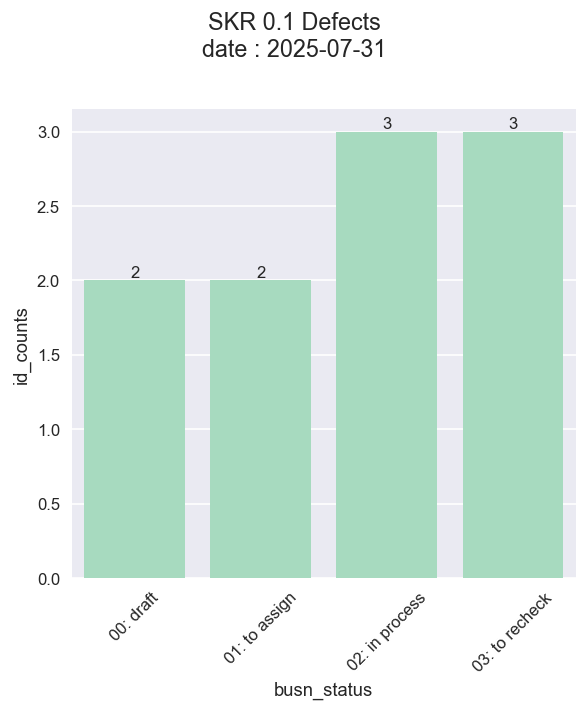

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,6), dpi=120 )

g = sns.barplot(
    data=status,
    x='busn_status',
    order = status['busn_status'].value_counts().index,
    y='id_counts',
    color='#9FE2BF',
    ax=axes
)

for tick in axes.get_xticklabels():
    tick.set_rotation(45)

### Show values in case multi-category
# for i in ax.containers:
#     ax.bar_label(i,)

### Show values in case single-category
axes.bar_label(axes.containers[0])

# g.set_title('flow_type')

fig.suptitle(f"SKR 0.1 Defects\ndate : {current_date}\n", fontsize=14)
fig.tight_layout()
plt.show()

In [11]:
status_priority = pd.DataFrame(df.groupby(by=['busn_status', 'priority'])['priority'].agg('count'))\
    .rename(columns={'priority':'pr_counts'})\
    # .reset_index(drop=False)

display(status_priority)

pr_counts
busn_status    priority           
00: draft      High              1
               Highest           1
01: to assign  High              1
               Highest           1
02: in process Highest           1
               Low               1
               Medium            1
03: to recheck High              1
               Highest           1
               Medium            1

priority,Highest,High,Medium,Low
busn_status,,,,
00: draft,1.0,1.0,0.0,0.0
01: to assign,1.0,1.0,0.0,0.0
02: in process,1.0,0.0,1.0,1.0
03: to recheck,1.0,1.0,1.0,0.0


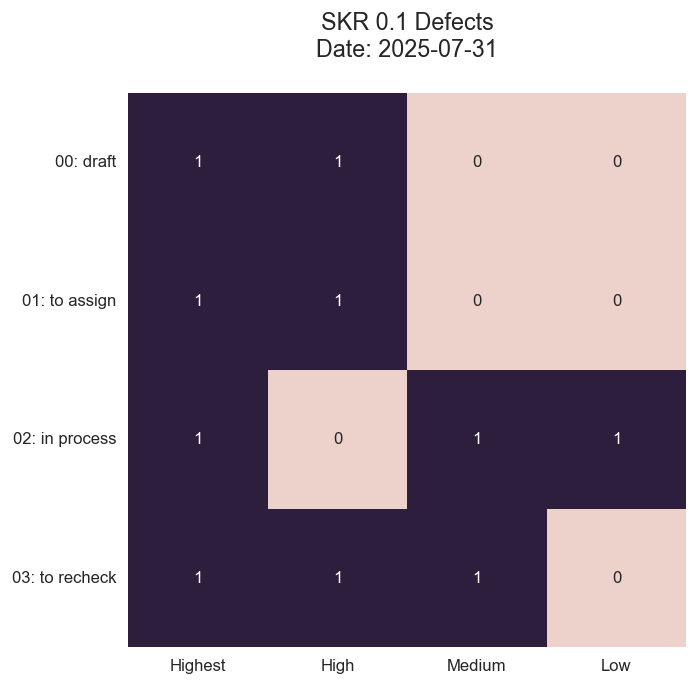

In [12]:
tmp = pd.DataFrame(df.groupby(by=['busn_status', 'priority'])['priority'].agg('count'))\
    .rename(columns={'priority':'pr_counts'})\
    .reset_index(drop=False)

tmp = tmp.pivot_table(index='busn_status', columns='priority', values='pr_counts')\
    # .reset_index(drop=False)
tmp = tmp.reindex(columns=['Highest', 'High', 'Medium', 'Low'])
tmp = tmp.fillna(0)
display(tmp)

### PLOT 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), dpi=120 )

ax = sns.heatmap(tmp, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), cbar=False)
plt.title('SKR 0.1 Defects\nDate: {a}\n'.format(a=current_date), fontsize=14)
ax.set(xlabel="", ylabel="")
ax.tick_params(axis='y', labelrotation=0)

In [13]:
for i in df['busn_status'].unique():
    print(f"STATUS: {i}")
    display(df[df['busn_status'] == i].sort_values(by=['priority'], ascending=False))

STATUS: 03: to recheck


,bug_id,status,priority,bug_name,created,duedate,Assignee,labels,link,busn_status
1,SKR-2221,Rechecking,Medium,[Appointment] กดทำนัดภายใต้ช่วงเวลา 48 ชั่วโมง...,2025-06-24T16:57:35.519+0700,2025-07-30,Tanawat Chanhom,"[SKR0.1, SKR0.1+, form, form-1]",https://skrmobileapp.atlassian.net/browse/SKR-...,03: to recheck
7,SKR-2249,fixed-deployed,Highest,[MO] หน้าจอไม่แสดงนัดหมายที่กำลังจะมาถึง x2,2025-07-14T13:27:46.087+0700,2025-08-01,Purinut Uomrod,"[SKR0.1, SKR0.1+, form, form-1]",https://skrmobileapp.atlassian.net/browse/SKR-...,03: to recheck
0,SKR-2309,Rechecking,High,"[BO,MO] Pre-register SKC ไม่สำเร็จ",2025-07-17T09:53:46.250+0700,2025-07-30,Tanawat Chanhom,"[SKR0.1, SKR0.1+, form, form-1]",https://skrmobileapp.atlassian.net/browse/SKR-...,03: to recheck


STATUS: 02: in process


,bug_id,status,priority,bug_name,created,duedate,Assignee,labels,link,busn_status
3,SKR-2325,ready-to-fix (assigned),Medium,"[BO] เพิ่มข้อมูลแพทย์ในเมนู""การจัดการแพทย์"" ส่...",2025-07-30T14:24:25.655+0700,None,Purinut Uomrod,"[SKR0.1, SKR0.1+, form, form-1]",https://skrmobileapp.atlassian.net/browse/SKR-...,02: in process
4,SKR-2323,ready-to-fix (assigned),Low,[BO] ยังไม่มีหน้า Noti ใน Back office,2025-07-30T09:18:06.139+0700,None,Tanawat Chanhom,"[SKR0.1, form, form-1]",https://skrmobileapp.atlassian.net/browse/SKR-...,02: in process
2,SKR-2265,ready-to-fix (assigned),Highest,[MO] ไม่สามารถยืนยันตัวตนด้วยบัตรประชาชนได้,2025-07-15T10:52:30.300+0700,2025-07-21,Pongpanot Na ubon,"[SKR0.1, SKR0.1+, form, form-1]",https://skrmobileapp.atlassian.net/browse/SKR-...,02: in process


STATUS: 00: draft


,bug_id,status,priority,bug_name,created,duedate,Assignee,labels,link,busn_status
5,SKR-2234,Draft ready,Highest,"[BO,Mobile] การแสดง ""ผลแล็บ"" ในเมนู ""ผลตรวจสุข...",2025-06-27T17:53:43.135+0700,None,manisara piboon,"[SKR0.1, SKR0.1+, form, form-1]",https://skrmobileapp.atlassian.net/browse/SKR-...,00: draft
6,SKR-2307,Draft ready,High,[MO] เปลี่ยนภาษาเป็น Eng แต่เมนูยังเป็นภาษาไทย,2025-07-16T13:52:40.108+0700,None,Pongpanot Na ubon,"[SKR0.1, SKR0.1+, form, form-1]",https://skrmobileapp.atlassian.net/browse/SKR-...,00: draft


STATUS: 01: to assign


,bug_id,status,priority,bug_name,created,duedate,Assignee,labels,link,busn_status
8,SKR-2324,To Do,Highest,"[BO] เพิ่ม ""แพทย์"" ในคลินิกเฉพาะทาง เพิ่มแล้วก...",2025-07-30T10:38:45.937+0700,None,None,"[SKR0.1, SKR0.1+, form, form-1]",https://skrmobileapp.atlassian.net/browse/SKR-...,01: to assign
9,SKR-2327,To Do,High,"[ MO, BO ] เปลี่ยนผล Lab SKC ที่เผยแพร่ไปแล้ว ...",2025-07-31T09:28:05.590+0700,None,None,"[SKR0.1, SKR0.1+, form, form-1]",https://skrmobileapp.atlassian.net/browse/SKR-...,01: to assign


## Report SKR 1.0

In [14]:
print(f"All Bugs : {len(df2)}")

All Bugs : 8


In [15]:
status2 = pd.DataFrame(df2.groupby(by=['busn_status'])['bug_id'].agg('count'))\
    .reset_index(drop=False)\
    .rename(columns={'bug_id':'id_counts'})

display(status2)

,busn_status,id_counts
0,00: draft,1
1,01: to assign,2
2,02: in process,4
3,03: to recheck,1


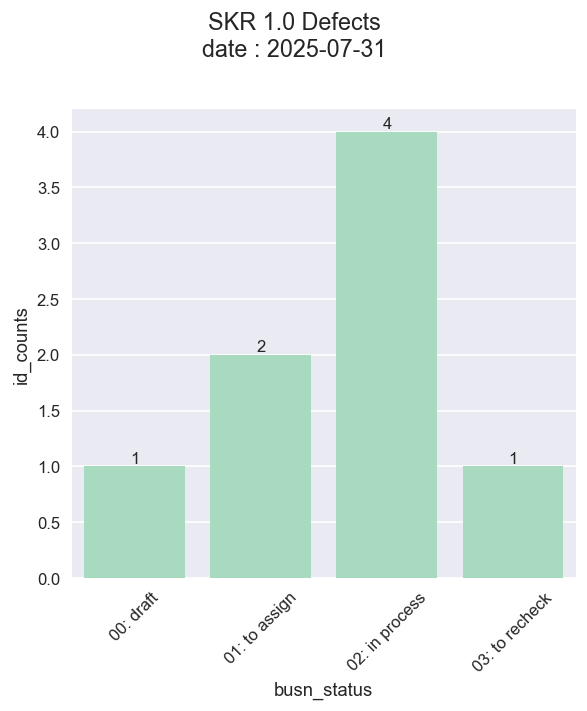

In [16]:
fig2, axes2 = plt.subplots(nrows=1, ncols=1, figsize=(5,6), dpi=120 )

g2 = sns.barplot(
    data=status2,
    x='busn_status',
    order = status['busn_status'].value_counts().index,
    y='id_counts',
    color='#9FE2BF',
    ax=axes2
)

for tickk in axes2.get_xticklabels():
    tickk.set_rotation(45)

### Show values in case multi-category
# for i in ax.containers:
#     axes2.bar_label(i,)

### Show values in case single-category
axes2.bar_label(axes2.containers[0])

# g2.set_title('flow_type')

fig2.suptitle(f"SKR 1.0 Defects\ndate : {current_date}\n", fontsize=14)
fig2.tight_layout()
plt.show()

In [17]:
status_priority2 = pd.DataFrame(df2.groupby(by=['busn_status', 'priority'])['priority'].agg('count'))\
    .rename(columns={'priority':'pr_counts'})\
    # .reset_index(drop=False)

display(status_priority2)

pr_counts
busn_status    priority           
00: draft      Medium            1
01: to assign  Medium            2
02: in process High              3
               Medium            1
03: to recheck Medium            1

priority,Highest,High,Medium,Low
busn_status,,,,
00: draft,0.0,0.0,1.0,0.0
01: to assign,0.0,0.0,2.0,0.0
02: in process,0.0,3.0,1.0,0.0
03: to recheck,0.0,0.0,1.0,0.0


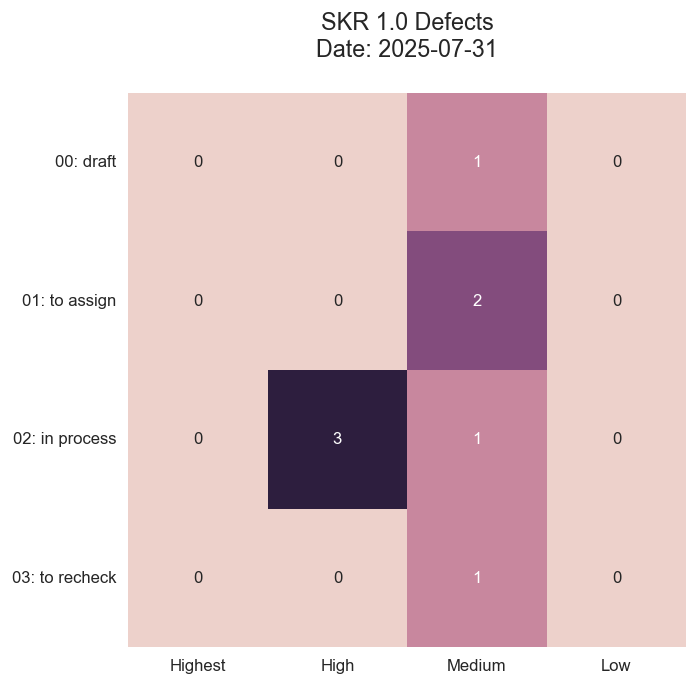

In [18]:
tmp2 = pd.DataFrame(df2.groupby(by=['busn_status', 'priority'])['priority'].agg('count'))\
    .rename(columns={'priority':'pr_counts'})\
    .reset_index(drop=False)

tmp2 = tmp2.pivot_table(index='busn_status', columns='priority', values='pr_counts')\
    # .reset_index(drop=False)

tmp2 = tmp2.reindex(columns=['Highest', 'High', 'Medium', 'Low'])
tmp2 = tmp2.fillna(0)
display(tmp2)

### PLOT 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), dpi=120 )

ax = sns.heatmap(tmp2, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), cbar=False)
plt.title('SKR 1.0 Defects\nDate: {a}\n'.format(a=current_date), fontsize=14)
ax.set(xlabel="", ylabel="")
ax.tick_params(axis='y', labelrotation=0)

In [19]:
for i2 in df2['busn_status'].unique():
    print(f"STATUS: {i2}")
    display(df2[df2['busn_status'] == i2].sort_values(by=['priority'], ascending=False))

STATUS: 03: to recheck


,bug_id,status,priority,bug_name,created,duedate,Assignee,labels,link,busn_status
0,SKR-2313,Rechecking,Medium,[BO] ไม่สามารถเลือกแจ้งเตือนเฉพาะ user ได้,2025-07-22T09:33:38.183+0700,2025-07-30,Purinut Uomrod,"[SKR0.1+, SKR1.0, form, form-1]",https://skrmobileapp.atlassian.net/browse/SKR-...,03: to recheck


STATUS: 02: in process


,bug_id,status,priority,bug_name,created,duedate,Assignee,labels,link,busn_status
4,SKR-2319,ready-to-fix (assigned),Medium,"[MO, Noti] Notification ที่อยู่นอก app ขึ้นมา ...",2025-07-24T13:23:26.978+0700,2025-07-30,Purinut Uomrod,"[SKR0.1+, SKR1.0, form, form-1]",https://skrmobileapp.atlassian.net/browse/SKR-...,02: in process
1,SKR-2259,ready-to-fix (assigned),High,"[BO, Noti] ไม่สามารถบันทึกเงื่อนไข Noti ได้ถูก...",2025-07-15T10:29:22.782+0700,2025-07-30,Purinut Uomrod,"[SKR0.1+, SKR1.0, form, form-1]",https://skrmobileapp.atlassian.net/browse/SKR-...,02: in process
2,SKR-2244,ready-to-fix (assigned),High,"[BO, Noti] Users don’t receive any automatic n...",2025-07-09T10:42:08.851+0700,2025-08-01,Purinut Uomrod,"[SKR0.1+, SKR1.0, form-1]",https://skrmobileapp.atlassian.net/browse/SKR-...,02: in process
3,SKR-2240,ready-to-fix (assigned),High,"[BO, Noti] ตัวแปร ไม่ทำงาน",2025-07-09T09:16:57.196+0700,2025-08-01,Nutsongwat Cheawka,"[SKR0.1+, SKR1.0, form, form-1]",https://skrmobileapp.atlassian.net/browse/SKR-...,02: in process


STATUS: 00: draft


,bug_id,status,priority,bug_name,created,duedate,Assignee,labels,link,busn_status
5,SKR-2331,Draft ready,Medium,Back Office : สร้างแจ้งเตือนอัตโนมัติแล้วเลือก...,2025-07-31T11:06:34.133+0700,None,None,"[SKR0.1+, SKR1.0, form, form-1]",https://skrmobileapp.atlassian.net/browse/SKR-...,00: draft


STATUS: 01: to assign


,bug_id,status,priority,bug_name,created,duedate,Assignee,labels,link,busn_status
6,SKR-2330,To Do,Medium,[ Noti ] ไม่ได้รับแจ้งเตือนแบบเงื่อนไข,2025-07-31T10:18:16.981+0700,None,None,"[SKR0.1+, SKR1.0, form, form-1]",https://skrmobileapp.atlassian.net/browse/SKR-...,01: to assign
7,SKR-2329,To Do,Medium,"[BO, Noti] drop down filter ในแจ้งเตือนอัติโนม...",2025-07-31T09:58:27.044+0700,None,None,"[SKR0.1+, SKR1.0, form, form-1]",https://skrmobileapp.atlassian.net/browse/SKR-...,01: to assign
